# Deep Learning e Computer Vision con Keras


### Cosa impareremo:
1. **Il paradigma del Deep Learning**: Differenze con il ML classico.
2. **L'ecosistema**: Confronto tecnico tra TensorFlow/Keras e PyTorch.
3. **Il Dataset MNIST**: Caricamento, Analisi Esplorativa (EDA) e Preprocessing.
4. **Anatomia di una CNN**: Filtri, Padding, Strati Convoluzionali e Pooling.
5. **Ottimizzazione**: Funzioni di attivazione (ReLU, Softmax) e algoritmi di discesa del gradiente.
6. **Addestramento e Diagnostica**: Analisi dell'Overfitting e matrici di confusione.

## 1. Fondamenti: Deep Learning vs Machine Learning

Nel Machine Learning tradizionale, il successo di un modello dipende dal **Feature Engineering**: l'esperto deve estrarre manualmente le caratteristiche rilevanti (es. i bordi di un oggetto o il colore). 

Il **Deep Learning** utilizza il concetto di *Representation Learning*. La rete neurale impara autonomamente a:
* Identificare pattern semplici (linee) nei primi strati.
* Combinare questi pattern in forme complesse (cerchi, angoli) negli strati intermedi.
* Riconoscere oggetti interi (numeri, volti) negli strati finali.

## 2. La Battaglia dei Framework: TensorFlow vs PyTorch

Prima di scrivere codice, è fondamentale capire gli strumenti a disposizione.

### TensorFlow e Keras (Google)
* **Punti di forza**: Estremamente scalabile, ideale per la produzione industriale (TF Serving), supporto massiccio per dispositivi mobili (TFLite).
* **Keras**: Originariamente una libreria indipendente, ora è l'API ufficiale di alto livello di TF. Rende la costruzione di reti complessa semplice come comporre mattoncini LEGO.

### PyTorch (Meta/Facebook)
* **Punti di forza**: Grafi computazionali dinamici. è il preferito dalla comunità di ricerca accademica perché il debug è più simile al Python standard.
* **Stile**: Richiede una scrittura più verbosa (bisogna definire classi e loop di training manuali).

**In questo notebook utilizzeremo Keras per la sua leggibilità e potenza nella prototipazione.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
from sklearn.metrics import confusion_matrix, classification_report

# Check for Apple Silicon GPU (MPS)
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    print(f"M4 GPU detected: {gpu_devices}")
    # TensorFlow 2.12+ automatically uses MPS if available
else:
    print("GPU not found. Ensure 'tensorflow-metal' is installed.")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


M4 GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 3. Analisi Esplorativa del Dataset MNIST

L'MNIST (Modified National Institute of Standards and Technology) contiene immagini $28 \times 28$ pixel. Carichiamo i dati e visualizziamo la distribuzione delle classi per assicurarci che il dataset sia bilanciato.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Immagini di training: (60000, 28, 28)
Immagini di test: (10000, 28, 28)


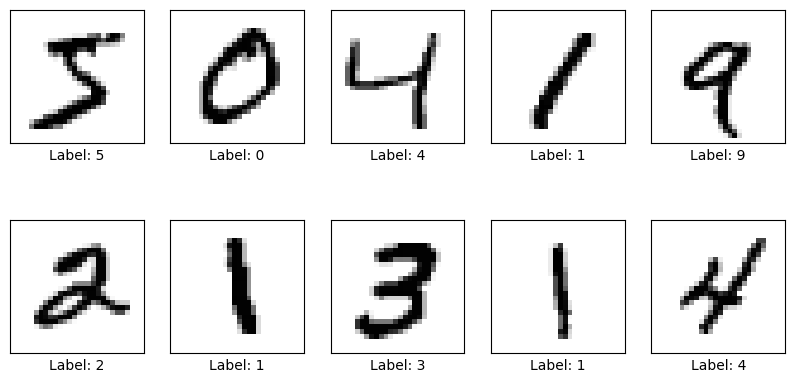

In [2]:
# Caricamento dei dati pre-suddivisi
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

print(f"Immagini di training: {train_images.shape}")
print(f"Immagini di test: {test_images.shape}")

# Visualizzazione di campioni casuali
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(f"Label: {train_labels[i]}")
plt.show()

## 4. Preprocessing dei Dati: Perché è necessario?

Prima di inviare le immagini alla CNN, dobbiamo effettuare due operazioni critiche:

1. **Reshape**: Le reti convoluzionali si aspettano un tensore a 4 dimensioni: `(Batch_Size, Altezza, Larghezza, Canali)`. Essendo MNIST in scala di grigi, il canale è 1.
2. **Normalizzazione**: I pixel hanno valori tra 0 e 255. Scalandoli tra 0 e 1, aiutiamo l'algoritmo di ottimizzazione (Adam) a trovare il minimo della funzione di perdita molto più velocemente, evitando esplosioni del gradiente.

In [3]:
# Reshape per aggiungere il canale singolo (grayscale)
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Conversione in float32 e Normalizzazione
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

print("Esempio di un pixel normalizzato:", train_images[0][15][15])

Esempio di un pixel normalizzato: [0.7294118]


## 5. Teoria delle CNN: I Componenti della Visione Artificiale

Una CNN non guarda l'immagine tutta insieme, ma attraverso piccole finestre mobili.

### A. Strato Convoluzionale (Conv2D)
Utilizza dei **Filtri** (es. matrici $3 \times 3$) che scorrono sull'immagine effettuando un prodotto scalare. Questo processo estrae le "Feature Maps".
### B. Funzione di Attivazione (ReLU)
La funzione *Rectified Linear Unit* f(x) = max(0, x) introduce la non-linearità. Senza di essa, la rete sarebbe solo una complessa operazione di regressione lineare.
### C. Max Pooling
Riduce la risoluzione spaziale. Se prendiamo il massimo in una finestra $2 \times 2$, riduciamo i dati del 75%, mantenendo solo il segnale più forte e rendendo la rete resistente a piccoli spostamenti dell'oggetto nell'immagine.



In [4]:
model = models.Sequential([
    # Primo blocco: 32 filtri per catturare bordi e linee semplici
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    
    # Secondo blocco: 64 filtri per combinare le linee in forme
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Terzo blocco: cattura pattern complessi della cifra
    layers.Conv2D(64, (3, 3), activation='relu'),
    
    # Head della rete: Classificazione
    layers.Flatten(), # Trasforma il tensore 2D in un vettore 1D
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax') # 10 neuroni per le 10 cifre, output = probabilità
])

model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-14 08:09:21.604997: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2026-01-14 08:09:21.605098: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-01-14 08:09:21.605110: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
I0000 00:00:1768374561.605409 6488689 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1768374561.605483 6488689 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Compilazione: Definire la Strategia di Apprendimento

* **Optimizer (Adam)**: è una variante della discesa stocastica del gradiente che adatta il learning rate per ogni parametro.
* **Loss (Sparse Categorical Crossentropy)**: Calcola l'errore tra la probabilità predetta e la classe reale. Usiamo "sparse" perché le nostre etichette sono numeri interi (0,1,2...) e non vettori *one-hot*.

In [5]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 7. Training del Modello

L'addestramento avviene in **Epoche**. Un'epoca è un passaggio completo di tutto il training set attraverso la rete. Utilizziamo il parametro `validation_split` per monitorare come la rete si comporta su dati che non ha mai visto durante ogni epoca.

In [6]:
history = model.fit(train_images, train_labels, 
                    epochs=10, 
                    batch_size=64,
                    validation_split=0.1)

Epoch 1/10


2026-01-14 08:09:24.001869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


844/844 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9378 - loss: 0.2016 - val_accuracy: 0.9788 - val_loss: 0.0713
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9816 - loss: 0.0593 - val_accuracy: 0.9885 - val_loss: 0.0443
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.9862 - loss: 0.0440 - val_accuracy: 0.9875 - val_loss: 0.0445
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.9888 - loss: 0.0352 - val_accuracy: 0.9825 - val_loss: 0.0695
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.9899 - loss: 0.0326 - val_accuracy: 0.9878 - val_loss: 0.0448
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.9918 - loss: 0.0265 - val_accuracy: 0.9900 - val_loss: 0.0406
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9924 - loss: 0.0260 - val_accuracy: 0.9910 - val_loss: 0.0480
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9931 - loss: 0.0234 - val_accurac

## 8. Analisi delle Performance e Matrice di Confusione

Un'accuratezza alta non dice tutto. Il modello confonde il 4 con il 9? Il 7 con l'1? 
Visualizzeremo le curve di apprendimento e la matrice di confusione per identificare i punti deboli del modello.

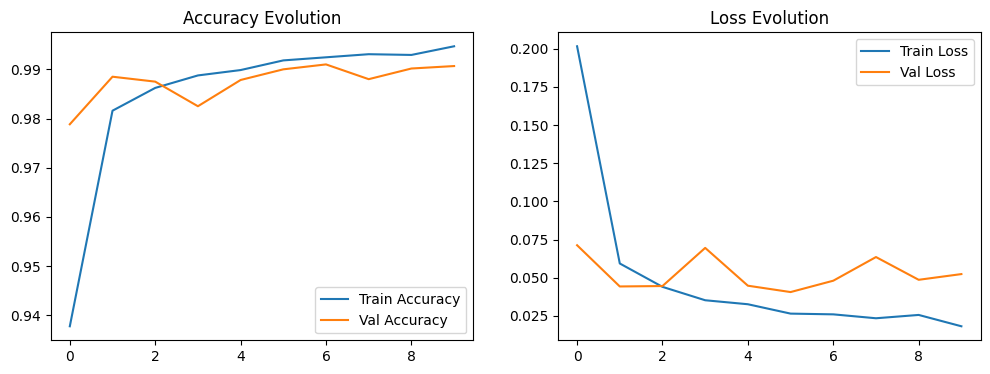

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


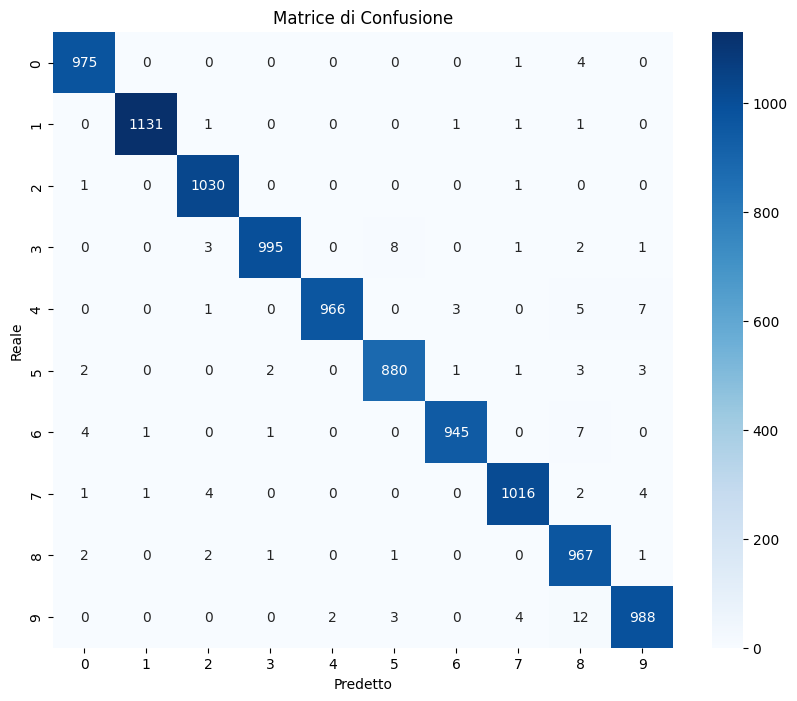

In [7]:
# Plotting Loss e Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Evolution')
plt.legend()
plt.show()

# Predizioni sul test set
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis=1)

# Generazione Matrice di Confusione
cm = confusion_matrix(test_labels, pred_labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.title('Matrice di Confusione')
plt.show()

## 9. Test Finale e Visualizzazione Predizioni

Infine, mettiamo alla prova il modello con immagini dal test set, visualizzando la probabilità che la rete assegna a ogni cifra.

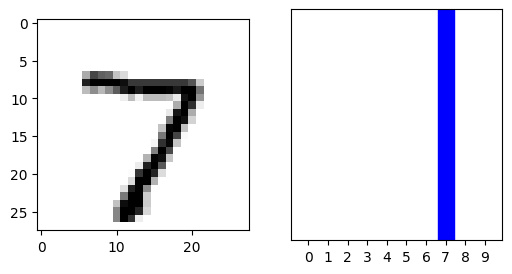

In [8]:
def plot_value_array(i, predictions_array, true_label):
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

i = 0 # Cambia questo indice per vedere altre cifre
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(test_images[i].reshape(28,28), cmap=plt.cm.binary)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels[i])
plt.show()

## 10. Conclusioni

Abbiamo costruito una CNN che raggiunge tipicamente un'accuratezza superiore al **99%** su MNIST. 

**Cosa fare ora?**
1. **Data Augmentation**: Prova a ruotare o zoomare le immagini per rendere la rete ancora più robusta.
2. **Dropout**: Aggiungi strati di `Dropout` per prevenire ulteriormente l'overfitting.
3. **Dataset complessi**: Applica la stessa logica a dataset a colori come CIFAR-10.